# DQN - Deep Q-Network  (PyTorch) - Flappy Bird.

In this notebook, we will use DQN with **experience replay** and **target networks** from `6.a-dqn-pytorch` to train the agent to play some other robotics environments. We will use pre-coded DQN from SB3 and SB3-Zoo to train agents. 


#### Running in Colab/Kaggle

If you are running this on Colab, please uncomment below cells and run this to install required dependencies.

In [ ]:
## uncomment and execute this cell to install all the the dependencies if running in Google Colab or Kaggle
# !apt-get update 
# !apt-get install -y swig cmake ffmpeg freeglut3-dev xvfb

In [ ]:
## Uncomment and execute this cell to install all the the dependencies if running in Google Colab or Kaggle

## Uncomment and run for Colab
# !git clone https://github.com/nsanghi/drl-2ed
# %cd /content/drl-2ed 
# !pip install  -r requirements.txt
# %cd chapter6


## Uncomment and run for Kaggle
# !git clone https://github.com/nsanghi/drl-2ed
# %cd /kaggle/working/drl-2ed 
# !pip install  -r requirements.txt
# %cd chapter6

In [ ]:
## Uncomment and Rerun the cd command in case you were asked to restart the kernel and you followed that message
## as after resart the kernel will again point back to root folder


## Uncomment and run for Colab
# %cd /content/drl-2ed 
# %cd chapter6


## Uncomment and run for Kaggle
# %cd /kaggle/working/drl-2ed 
# %cd chapter6

### Imports

In [ ]:
# uncomment and execute this cell to install all the the dependencies if running in Google Colab
# takes about 10-12 minutes to install all the dependencies esp the ones with RL Zoo

# !apt-get update && apt-get install swig cmake ffmpeg freeglut3-dev xvfb
# !pip install box2d-py
# !pip install "stable-baselines3[extra]>=2.1"
# !pip install "huggingface_sb3>=3.0"

# !pip install git+https://github.com/DLR-RM/rl-baselines3-zoo@update/hf
# !git clone --recursive https://github.com/DLR-RM/rl-baselines3-zoo
# %cd /content/rl-baselines3-zoo/
# !pip install -r requirements.txt
# %cd ..
# pip install flappy-bird-gymnasium

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from base64 import b64encode

import flappy_bird_gymnasium

from IPython.display import HTML

%matplotlib inline


2024-04-16 14:20:02.299472: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 14:20:02.301724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 14:20:02.338076: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 14:20:02.338113: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 14:20:02.338133: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

### Environment - Flappy Bird


The observation space is a 12 dimension value with following meaning

```
	1. the last pipe's horizontal position
	2. the last top pipe's vertical position
	3. the last bottom pipe's vertical position
	4. the next pipe's horizontal position
	5. the next top pipe's vertical position
	6. the next bottom pipe's vertical position
	7. the next next pipe's horizontal position
	8. the next next top pipe's vertical position
	9. the next next bottom pipe's vertical position
	10. player's vertical position
	11. player's vertical velocity
	12. player's rotation
```

The action space is Discrete with two values:

```
	1. Do nothing - "0"
	2. Flap - "1"
```

Rewards

```
+0.1 - every frame it stays alive
+1.0 - successfully passing a pipe
-1.0 - dying
```
ing

In [2]:
def make_env(env_id):
    env = gym.make(env_id, render_mode="rgb_array")
    return env

state shape:(12,)
Number of Actions:2


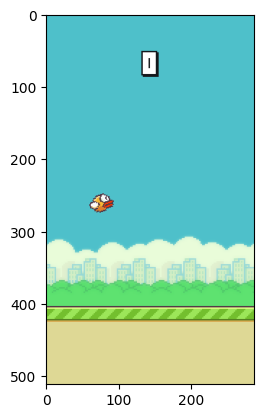

In [3]:
env_id = "FlappyBird-v0"

seed=123
env = make_env(env_id)
env.reset(seed=seed)
plt.imshow(env.render())
state_shape, n_actions = env.observation_space.shape, env.action_space.n
print(f"state shape:{state_shape}\nNumber of Actions:{n_actions}")

#### We can play the game

use `Space-bar` on keyboard to move the bird up and `Space-bar`. use `Esc` to kill the game.

**NOTE: Running the cell below may crash your kernel in Mac. If you face that problem, please comment the cell below or do not run it**.

In [4]:
from gymnasium.utils.play import play

play(env=gym.make(env_id,
                  render_mode='rgb_array'), keys_to_action={" ":1}, zoom=3)

/home/nsanghi/sandbox/apress/drl-2ed/venv39/lib/python3.9/site-packages/gymnasium/utils/play.py:29: UserWarning: WARN: matplotlib is not installed, run `pip install gymnasium[other]`
  logger.warn("matplotlib is not installed, run `pip install gymnasium[other]`")


### Train DQN using SB3

We will train the model using stablebaseline3 (sb3) and upload the model to hugging face using utilities provided in sb3.

#### Create DQN Agent
We will create a DQN agent with default MLP architecture i.e. with two Fully Connected Linear layers of size 64

In [5]:
# create the DQN agent
from stable_baselines3 import DQN

env = gym.make(env_id)
model = DQN("MlpPolicy", env, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


#### Print the Policy Network

In [6]:
model.policy

DQNPolicy(
  (q_net): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=12, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=12, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
)

#### Train the model

In [7]:
model.learn(total_timesteps=2*1e5, log_interval=500, progress_bar=True)
model.save("logs/6_e/sb3/dqn_flappy")

Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.3     |
|    ep_rew_mean      | 8.73     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 500      |
|    fps              | 11473    |
|    time_elapsed     | 4        |
|    total_timesteps  | 50235    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00638  |
|    n_updates        | 58       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.2     |
|    ep_rew_mean      | 8.84     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1000     |
|    fps              | 1596     |
|    time_elapsed     | 61       |
|    total_timesteps  | 97425    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000675 |
|    n_updates      

/home/nsanghi/sandbox/apress/drl-2ed/venv39/lib/python3.9/site-packages/stable_baselines3/common/save_util.py:278: UserWarning: Path 'logs/6_e/sb3' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [9]:
dir(model)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_convert_train_freq',
 '_create_aliases',
 '_current_progress_remaining',
 '_custom_logger',
 '_dump_logs',
 '_episode_num',
 '_episode_storage',
 '_excluded_save_params',
 '_get_policy_from_name',
 '_get_torch_save_params',
 '_init_callback',
 '_last_episode_starts',
 '_last_obs',
 '_last_original_obs',
 '_logger',
 '_n_calls',
 '_n_updates',
 '_num_timesteps_at_start',
 '_on_step',
 '_sample_action',
 '_setup_learn',
 '_setup_lr_schedule',
 '_setup_model',
 '_stats_window_size',
 '_store_transition',
 '_total_timesteps',
 '_update_current_progress_

#### Recrod Video

In [13]:
# Helper function to record videos for sb3 model
def record_video(env_id, video_folder, video_length, agent):

    vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Record the video starting at the first step
    vec_env = VecVideoRecorder(vec_env, video_folder,
                           record_video_trigger=lambda x: x == 0, video_length=video_length,
                           name_prefix=f"{type(agent).__name__}-{env_id}")

    obs = vec_env.reset()
    for _ in range(video_length + 1):
        action,_ = agent.predict(obs, deterministic=True)
        obs, _, _, _ = vec_env.step(action)
    # video filename
    file_path = "./"+video_folder+vec_env.video_recorder.path.split("/")[-1]
    # Save the video
    vec_env.close()
    return file_path

def play_video(file_path):
    mp4 = open(file_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
        <video width=200 controls>
              <source src="%s" type="video/mp4">
        </video>
        """ % data_url)


video_folder = "logs/6_e/sb3/videos/"
video_length = 1000

video_file_sb3 = record_video(env_id, video_folder, video_length, model)
play_video(video_file_sb3)

Saving video to /home/nsanghi/sandbox/apress/drl-2ed/chapter6/logs/6_e/sb3/videos/DQN-FlappyBird-v0-step-0-to-step-1000.mp4
Moviepy - Building video /home/nsanghi/sandbox/apress/drl-2ed/chapter6/logs/6_e/sb3/videos/DQN-FlappyBird-v0-step-0-to-step-1000.mp4.
Moviepy - Writing video /home/nsanghi/sandbox/apress/drl-2ed/chapter6/logs/6_e/sb3/videos/DQN-FlappyBird-v0-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /home/nsanghi/sandbox/apress/drl-2ed/chapter6/logs/6_e/sb3/videos/DQN-FlappyBird-v0-step-0-to-step-1000.mp4


#### Share the agent using HuggingFace

Get your Hugging Face token ready as we will need in next code cell to be able to login into your hugging face account

**Enter your Token**

In [14]:
from huggingface_sb3 import load_from_hub, package_to_hub, push_to_hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.

notebook_login()
!git config --global credential.helper store

**IMPORTANT**
Some users have reported facing following error while running the `package_to_hub` upload function. 

```
"Token is required (write-access action) but no token found. You need to provide a token or be logged in to Hugging Face with `huggingface-cli login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens."
```

In such a case the following command will help you over come the issue

```
import huggingface_hub

huggingface_hub.login(token= <YOUR_HF_TOKEN>,
                     write_permission = True,
                    add_to_git_credential = True)
					
```

Another alternative is to use following command from command shell where the `venv` or `conda` environment for this repository has been activated and then follow the instructions to set the HuggingFace token.

```
huggingface-cli login

```

In [15]:
eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
obs = eval_env.reset()

# method save, evaluate, generate a model card and record a replay video of your agent before pushing the repo to the hub

# Please note repo_id is of the form <huggingface_id>/<name of repo>
# you will need to change this to "<your_huggingface_id>/dqn-cart-pole-v1"

package_to_hub(model=model, # Our trained model
               model_name= "DQN-" + env_id, # The name of our trained model
               model_architecture="DQN", # The model architecture we used: in our case PPO
               env_id=env_id, # Name of the environment
               eval_env=eval_env, # Evaluation Environment
               repo_id="nsanghi/dqn-flappy-sb3", # id of the model repository from the Hugging Face Hub (repo_id = {organization}/{repo_name}
               commit_message="Push to Hub")

ℹ This function will save, evaluate, generate a video of your agent,
create a model card and push everything to the hub. It might take up to 1min.
This is a work in progress: if you encounter a bug, please open an issue.


/home/nsanghi/sandbox/apress/drl-2ed/venv39/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Saving video to /tmp/tmp_uyw1nqr/-step-0-to-step-1000.mp4
Moviepy - Building video /tmp/tmp_uyw1nqr/-step-0-to-step-1000.mp4.
Moviepy - Writing video /tmp/tmp_uyw1nqr/-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp_uyw1nqr/-step-0-to-step-1000.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

ℹ Pushing repo nsanghi/dqn-flappy-sb3 to the Hugging Face Hub


policy.pth:   0%|          | 0.00/45.4k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

policy.optimizer.pth:   0%|          | 0.00/46.2k [00:00<?, ?B/s]

pytorch_variables.pth:   0%|          | 0.00/864 [00:00<?, ?B/s]

DQN-FlappyBird-v0.zip:   0%|          | 0.00/109k [00:00<?, ?B/s]

ℹ Your model is pushed to the Hub. You can view your model here:
https://huggingface.co/nsanghi/dqn-flappy-sb3/tree/main/


'https://huggingface.co/nsanghi/dqn-flappy-sb3/tree/main/'

### Summary

In this notebook we saw how to train a DQN agent to play Flappy. If you have access to a GPU, try to train the agent more and see how well it plays.